In [1]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
def read_and_concat(file_list):
    dfs = [pd.read_csv(f) for f in file_list]
    return pd.concat(dfs, ignore_index=True)

In [23]:
import glob
import pandas as pd

file_list_2022 = glob.glob("2022/*.csv")
file_list_2023 = glob.glob("2023/*.csv")
file_list_2024 = glob.glob("2024/*.csv")
file_list_2025 = glob.glob("2025/*.csv")

In [24]:
df_2022 = read_and_concat(file_list_2022)
df_2023 = read_and_concat(file_list_2023)
df_2024 = read_and_concat(file_list_2024)
df_2025 = read_and_concat(file_list_2025)

temp = pd.concat([df_2022, df_2023, df_2024, df_2025], ignore_index=True)
temp = temp.dropna(subset=["FinishingPos"])

X = temp.drop(["FinishingPos", "Retired"], axis=1)
y = temp["FinishingPos"]

In [25]:
df_2022 = read_and_concat(file_list_2022)
df_2023 = read_and_concat(file_list_2023)
df_2024 = read_and_concat(file_list_2024)
df_2025 = read_and_concat(file_list_2025)

big_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)
big_df = big_df.dropna(subset=["FinishingPos"])

In [26]:
X_train = big_df.drop(["FinishingPos", "Retired"], axis=1)
y_train = big_df["FinishingPos"]

In [27]:
test_df = read_and_concat(file_list_2025)
test_df = test_df.dropna(subset=["FinishingPos"])

In [28]:
X_test = test_df.drop(["FinishingPos", "Retired"], axis=1)
Y_test = test_df["FinishingPos"]

In [31]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [154]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators" : [i for i in range(1, 1001, 10)],
    "max_depth" : [i for i in range(1,101)],
    "min_samples_split" : [i for i in range(2,101)],
    "min_samples_leaf" : [i for i in range(1,101)],
    "max_features" : ["sqrt", "log2", None],
    "bootstrap" : [True],
    "max_samples" : [0.5, 0.6, 0.7, 0.8, 0.9],
    "random_state" : [30],
    "oob_score" : [True],
    "criterion" : ["absolute_error"]
}

rfr = RandomForestRegressor(random_state=30)
rfr = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist,
    n_iter=200,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring="neg_mean_squared_error"
)

Using custom weights below did not improve model accuracy

In [125]:
import numpy as np

# Example: assume you already have a column 'RaceIndex' where
# 2022 Bahrain = 0, ..., 2024 Abu Dhabi = max_index
min_idx = X_train["RacesInGEEra"].min()
max_idx = X_train["RacesInGEEra"].max()

# Normalize RaceIndex into [0, 1]
norm_idx = (X_train["RacesInGEEra"] - min_idx) / (max_idx - min_idx)

# Linear weights from 0.1 to 1.0
weights = 0.05 + 0.9 * norm_idx


In [87]:
decay_rate = 0.05
max_index = X_train["RacesInGEEra"].max()
distance = max_index - X_train["RacesInGEEra"]

weights = np.exp(-decay_rate * distance)

In [146]:
# Define a function to get a weight by season
def weight_by_season(x):
    weights_2022 = 0.2
    weights_2023 = 0.7
    weights_2024 = 1.3
    if x[1]["Season"] == 2022:
        return weights_2022 * x[1]["RoundNumber"]
    elif x[1]["Season"] == 2023:
        return (weights_2022 * 22) + (weights_2023 * x[1]["RoundNumber"])
    else:
        return (weights_2022 * 22) + (weights_2023 * 22) + (weights_2024 * x[1]["RoundNumber"])

# Build the full sample_weight array for all driver samples
weights = []
for x in X_train.iterrows():
    race_weight = weight_by_season(x)
    weights.extend([race_weight])  # 20 drivers per race

weights = np.array(weights)

Training the model below

In [155]:
rfr.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


,estimator,RandomForestR...ndom_state=30)
,param_distributions,"{'bootstrap': [True], 'criterion': ['absolute_error'], 'max_depth': [1, 2, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,n_iter,200
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [4]:
def get_df_preds(X_test, Y_pred):
    df_preds = pd.DataFrame({
        "RaceId" : X_test["RacesInGEEra"],
        "PredictedValue" : Y_pred
    })

    # argsort the race predictions made by the model
    # each race is grouped by RacesInGEEra
    df_preds["PredictedRank"] = df_preds.groupby("RaceId")["PredictedValue"].rank(method="first", ascending=True).astype(int)

    return df_preds

In [52]:
Y_pred = model.predict(X_test)
df_preds = get_df_preds(X_test, Y_pred)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, median_absolute_error
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr, kendalltau

r2 = r2_score(Y_test, df_preds["PredictedRank"])
print("MAE:", mean_absolute_error(Y_test, df_preds["PredictedRank"]))
print("MSE:", mean_squared_error(Y_test, df_preds["PredictedRank"]))
print("r2:", r2)
print("RMSE:", root_mean_squared_error(Y_test, df_preds["PredictedRank"]))
print("MEAE:", median_absolute_error(Y_test, df_preds["PredictedRank"]))
print("Spearmanr:", spearmanr(Y_test, df_preds["PredictedRank"])[0])
print("Kendalltau:", kendalltau(Y_test, df_preds["PredictedRank"])[0])

NameError: name 'Y_test' is not defined

In [54]:
for file in file_list_2025:
    spa = pd.read_csv(file)
    spa = spa.dropna(subset=["FinishingPos"])
    spa_X = spa.drop(["FinishingPos", "Retired"], axis=1)
    spa_Y = spa["FinishingPos"]

    spa_Y_pred = model.predict(spa_X)

    print(r2_score(spa_Y, get_df_preds(spa_X, spa_Y_pred)["PredictedRank"]), file)

0.25263157894736843 2025\Barcelona_race.csv
0.5067669172932331 2025\Budapest_race.csv
0.3984962406015038 2025\Imola_race.csv
0.4045112781954887 2025\Jeddah_race.csv
0.43157894736842106 2025\Melbourne_race.csv
0.7894736842105263 2025\Miami_race.csv
0.08571428571428574 2025\Monaco_race.csv
0.4977443609022556 2025\Montreal_race.csv
0.5067669172932331 2025\Monza_race.csv
0.443609022556391 2025\Sakhir_race.csv
0.004511278195488688 2025\Shanghai_race.csv
0.1578947368421053 2025\Silverstone_race.csv
0.19999999999999996 2025\Spa-Francorchamps_race.csv
-0.23308270676691722 2025\Spielberg_race.csv
0.8135338345864662 2025\Suzuka_race.csv
-0.299248120300752 2025\Zandvoort_race.csv


In [55]:
race = pd.read_csv("2025/Suzuka_race.csv")
race = race.dropna(subset=["FinishingPos"])
race_X = race.drop(["FinishingPos", "Retired"], axis=1)
race_Y = race["FinishingPos"]

race_Y_pred = model.predict(race_X)

df_preds = get_df_preds(race_X, race_Y_pred)

r2 = r2_score(race_Y, df_preds["PredictedRank"])
print("MAE:", mean_absolute_error(race_Y, df_preds["PredictedRank"]))
print("MSE:", mean_squared_error(race_Y, df_preds["PredictedRank"]))
print("r2:", r2)
print("RMSE:", root_mean_squared_error(race_Y, df_preds["PredictedRank"]))
print("MEAE:", median_absolute_error(race_Y, df_preds["PredictedRank"]))
print("Spearmanr:", spearmanr(race_Y, df_preds["PredictedRank"])[0])
print("Kendalltau:", kendalltau(race_Y, df_preds["PredictedRank"])[0])

MAE: 1.6
MSE: 6.2
r2: 0.8135338345864662
RMSE: 2.4899799195977463
MEAE: 1.0
Spearmanr: 0.9067669172932331
Kendalltau: 0.8105263157894737


In [10]:
driver_names = {
    1: 'Charles Leclerc',
    2: 'Carlos Sainz',
    3: 'Lewis Hamilton',
    4: 'George Russell',
    5: 'Kevin Magnussen',
    6: 'Valtteri Bottas',
    7: 'Esteban Ocon',
    8: 'Yuki Tsunoda',
    9: 'Fernando Alonso',
    10: 'Guanyu Zhou',
    11: 'Mick Schumacher',
    12: 'Lance Stroll',
    13: 'Alexander Albon',
    14: 'Daniel Ricciardo',
    15: 'Lando Norris',
    16: 'Nicholas Latifi',
    17: 'Nico Hulkenberg',
    18: 'Sergio Perez',
    19: 'Max Verstappen',
    20: 'Pierre Gasly',
    21: 'Sebastian Vettel',
    22: 'Nyck De Vries',
    23: 'Logan Sargeant',
    24: 'Oscar Piastri',
    25: 'Liam Lawson',
    26: 'Oliver Bearman',
    27: 'Franco Colapinto',
    28: 'Jack Doohan',
    29: 'Andrea Kimi Antonelli',
    30: 'Gabriel Bortoleto',
    31: 'Isack Hadjar',
    32: 'Kimi Antonelli'
}

In [57]:
df_pred = get_df_preds(race_X, race_Y_pred)
print("Driver - Qualifying Position - Predicted Finish - Actual Finish")
for i, pred in df_pred.iterrows():
    print(f"{driver_names[race_X["DriverId"][i]]} - {race_X["QualifyingPos"][i]} - {pred["PredictedRank"]} - {race_Y[i]} - {race_Y_pred[i]}")

Driver - Qualifying Position - Predicted Finish - Actual Finish
Max Verstappen - 1.0 - 1.0 - 1.0 - 0.9256367087364197
Lando Norris - 2.0 - 2.0 - 2.0 - 1.4013385772705078
Oscar Piastri - 3.0 - 3.0 - 3.0 - 1.4013385772705078
Charles Leclerc - 4.0 - 6.0 - 4.0 - 1.6885876655578613
George Russell - 5.0 - 4.0 - 5.0 - 1.675004005432129
Kimi Antonelli - 6.0 - 5.0 - 6.0 - 1.675004005432129
Lewis Hamilton - 8.0 - 8.0 - 7.0 - 1.9422798156738281
Isack Hadjar - 7.0 - 9.0 - 8.0 - 1.9422798156738281
Alexander Albon - 9.0 - 10.0 - 9.0 - 1.9422798156738281
Oliver Bearman - 10.0 - 14.0 - 10.0 - 2.3580732345581055
Fernando Alonso - 13.0 - 11.0 - 11.0 - 2.1016478538513184
Yuki Tsunoda - 15.0 - 7.0 - 12.0 - 1.882371425628662
Pierre Gasly - 11.0 - 15.0 - 13.0 - 2.3580732345581055
Carlos Sainz - 12.0 - 13.0 - 14.0 - 2.1043806076049805
Jack Doohan - 19.0 - 16.0 - 15.0 - 2.3580732345581055
Nico Hulkenberg - 16.0 - 17.0 - 16.0 - 2.3580732345581055
Liam Lawson - 14.0 - 18.0 - 17.0 - 2.3580732345581055
Esteban Oc

In [ ]:
best_rf = rfr.best_estimator_

importances = best_rf.feature_importances_
feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                  Feature  Importance
1                  TeamId    0.152319
13              GapToPole    0.152173
10       RelativeHumidity    0.148545
9            ApparentTemp    0.142636
4            RacesInGEEra    0.137075
12          QualifyingPos    0.133928
8               WindSpeed    0.133323
6              RainBefore    0.000000
5              LocationId    0.000000
3             RoundNumber    0.000000
2                  Season    0.000000
0                DriverId    0.000000
7              RainDuring    0.000000
11            StartingPos    0.000000
14  TeammateQualifyingPos    0.000000


In [44]:
import pickle

with open("xgb_model2.pkl", "wb") as file:
    pickle.dump(model, file)

In [1]:
import pickle

with open('xgb_model1.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

In [2]:
import pickle

with open('best_rfr_model.pkl', 'rb') as file:
    rfr_model = pickle.load(file)

In [12]:
import pandas as pd
with open("Baku_race.csv", "r") as file:
    monza = pd.read_csv(file)

In [13]:
monza_quali = monza.drop(["Retired", "FinishingPos"], axis=1)
monza_results = monza["FinishingPos"]

In [14]:
xgb_predicted_positions = xgb_model.predict(monza_quali)
rfr_predicted_positions = rfr_model.predict(monza_quali)

In [15]:
xgb_df_pred = get_df_preds(monza_quali, xgb_predicted_positions)
rfr_df_pred = get_df_preds(monza_quali, rfr_predicted_positions)
print("Driver - Quali Pos - Model 1 - Model 2 - Actual Finishing Pos")
for i, pred in xgb_df_pred.iterrows():
    print(f"{driver_names[monza_quali["DriverId"][i]]} - {monza_quali["StartingPos"][i]} - {rfr_df_pred["PredictedRank"][i]} - {xgb_df_pred["PredictedRank"][i]} - {monza_results[i]}")

Driver - Quali Pos - Model 1 - Model 2 - Actual Finishing Pos
Max Verstappen - 1.0 - 1 - 1 - 1.0
Carlos Sainz - 2.0 - 4 - 3 - 3.0
Liam Lawson - 3.0 - 6 - 7 - 5.0
Kimi Antonelli - 4.0 - 2 - 4 - 4.0
George Russell - 5.0 - 3 - 5 - 2.0
Yuki Tsunoda - 6.0 - 5 - 2 - 6.0
Lando Norris - 7.0 - 7 - 9 - 7.0
Isack Hadjar - 8.0 - 11 - 10 - 10.0
Oscar Piastri - 9.0 - 9 - 6 - 20.0
Charles Leclerc - 10.0 - 8 - 8 - 9.0
Fernando Alonso - 11.0 - 12 - 11 - 15.0
Lewis Hamilton - 12.0 - 10 - 12 - 8.0
Gabriel Bortoleto - 13.0 - 13 - 13 - 11.0
Lance Stroll - 14.0 - 14 - 14 - 17.0
Oliver Bearman - 15.0 - 16 - 15 - 12.0
Franco Colapinto - 16.0 - 17 - 16 - 19.0
Nico Hulkenberg - 17.0 - 18 - 17 - 16.0
Pierre Gasly - 18.0 - 19 - 18 - 18.0
Alexander Albon - 19.0 - 15 - 19 - 13.0
Esteban Ocon - 20.0 - 20 - 20 - 14.0


In [19]:
print("MAE:", mean_absolute_error(monza_results, xgb_df_pred["PredictedRank"]), mean_absolute_error(monza_results, rfr_df_pred["PredictedRank"]))
print("MSE:", mean_squared_error(monza_results, xgb_df_pred["PredictedRank"]), mean_squared_error(monza_results, rfr_df_pred["PredictedRank"]))
print("r2:", r2_score(monza_results, xgb_df_pred["PredictedRank"]), r2_score(monza_results, rfr_df_pred["PredictedRank"]))
print("RMSE:", root_mean_squared_error(monza_results, xgb_df_pred["PredictedRank"]), root_mean_squared_error(monza_results, rfr_df_pred["PredictedRank"]))
print("MEAE:", median_absolute_error(monza_results, xgb_df_pred["PredictedRank"]), median_absolute_error(monza_results, rfr_df_pred["PredictedRank"]))
print("Spearmanr:", spearmanr(monza_results, xgb_df_pred["PredictedRank"])[0], spearmanr(monza_results, rfr_df_pred["PredictedRank"])[0])
print("Kendalltau:", kendalltau(monza_results, xgb_df_pred["PredictedRank"])[0], kendalltau(monza_results, rfr_df_pred["PredictedRank"])[0])

MAE: 2.9 2.3
MSE: 18.3 11.1
r2: 0.4496240601503759 0.6661654135338346
RMSE: 4.277849927241488 3.331666249791536
MEAE: 2.5 2.0
Spearmanr: 0.724812030075188 0.8330827067669173
Kendalltau: 0.5789473684210527 0.6947368421052632


In [2]:
import xgboost as xgb

In [69]:
dtrain = xgb.DMatrix(X_train, device="cuda", label=y_train)
dtest = xgb.DMatrix(X_test, device="cuda", label=Y_test)


TypeError: DMatrix.__init__() got an unexpected keyword argument 'device'

In [ ]:
params = {
    "max_depth" : [i for i in range(1, 11)],
    "objective" : ["rank:pairwise", "rank:ndcg", "rank:map"],
    "learning_rate" : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
    "n_estimators" : [i for i in range(100, 1001, 100)],
    "subsample" : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ],
    "min_child_weight" : [i for i in range(1, 11)],
    "gamma" : [i for i in range(6)],
    "lambda" : [i for i in range(1,6)],
    "alpha" : [0, 1],
    "eval_metric" : ["ndcg", "map"],
    "lambdarank_num_pair_per_sample" : [i for i in range(1, 11)],
    "seed" : [30]
}

In [29]:
curr_race = None
count = 1
groups = []
for sample in X.iterrows():
    if curr_race == None:
        curr_race = sample[1]["RacesInGEEra"]
    elif curr_race != sample[1]["RacesInGEEra"]:
        groups.append(count)
        count = 1
        curr_race = sample[1]["RacesInGEEra"]
    else:
        count += 1

groups.append(count)

In [30]:
curr_race = None
count = 1
group_train = []
for sample in X_train.iterrows():
    if curr_race == None:
        curr_race = sample[1]["RacesInGEEra"]
    elif curr_race != sample[1]["RacesInGEEra"]:
        group_train.append(count)
        count = 1
        curr_race = sample[1]["RacesInGEEra"]
    else:
        count += 1

group_train.append(count)

In [31]:
curr_race = None
count = 1
group_test = []
for sample in X_test.iterrows():
    if curr_race == None:
        curr_race = sample[1]["RacesInGEEra"]
    elif curr_race != sample[1]["RacesInGEEra"]:
        group_test.append(count)
        count = 1
        curr_race = sample[1]["RacesInGEEra"]
    else:
        count += 1

group_test.append(count)

In [45]:
from sklearn.pipeline import Pipeline

estimators = [
    ('clf', xgb.XGBRegressor(random_state=30))
]
pipe = Pipeline(steps=estimators)
pipe

,steps,"[('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None


In [46]:
from skopt.space import Real, Integer
params = {
    "clf__max_leaves": Integer(32, 64),              # Deeper trees can use more feature combinations
    "clf__objective": ["rank:ndcg"],              # Keep ndcg since it's working
    "clf__learning_rate": Real(0.02, 0.17),      # Lower rate for more thorough learning
    "clf__n_estimators": Integer(300, 1200),      # More rounds to explore features
    "clf__subsample": Real(0.6, 0.85),            # Slight subsampling for regularization
    "clf__colsample_bytree": Real(0.6, 0.85),     # Keep high to allow feature access
    "clf__min_child_weight": [1],      # Lower values allow smaller splits
    "clf__gamma": Real(0, 1),                    # Lower penalty encourages more splits
    "clf__lambda": Real(0.1, 1),                 # Small regularization for stability
    "clf__alpha": Real(0, 0.75),                  # Light L1 regularization
    "clf__eval_metric": ["ndcg"],
    "clf__lambdarank_num_pair_per_sample": Integer(2, 4),
    "clf__seed": [30],
    "clf__device": ["cuda"],
    "clf__tree_method" : ["hist"],
    "clf__grow_policy" : ["lossguide"]
}

In [47]:
from skopt import BayesSearchCV

model = BayesSearchCV(pipe, params, cv=5, n_iter=50, scoring="neg_mean_squared_error", random_state=30)

In [49]:
model.fit(X_train, y_train)

,estimator,"Pipeline(step...=None, ...))])"
,search_spaces,"{'clf__alpha': Real(low=0, h...m='normalize'), 'clf__colsample_bytree': Real(low=0.6,...m='normalize'), 'clf__device': ['cuda'], 'clf__eval_metric': ['ndcg'], ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [50]:
model.predict(X_test)

array([1.4013386 , 1.6717889 , 1.6885877 , 1.4045134 , 2.3580732 ,
       1.9422798 , 2.209784  , 1.9422798 , 2.1016479 , 1.1960878 ,
       2.3580732 , 2.3580732 , 1.8823714 , 2.1043806 , 2.3580732 ,
       2.3580732 , 2.3580732 , 1.675004  , 2.3580732 , 1.4013386 ,
       1.4013386 , 1.134062  , 1.1476462 , 1.1449132 , 1.9422798 ,
       1.1449132 , 1.9422798 , 1.4665792 , 2.090797  , 2.0905685 ,
       2.0905685 , 2.3580732 , 1.8368766 , 2.3580732 , 2.0905685 ,
       1.6148686 , 2.3580732 , 2.0905685 , 2.0905685 , 0.37883303,
       1.1249862 , 0.85453445, 1.81127   , 1.6629817 , 1.557579  ,
       0.58725816, 1.4092898 , 1.6629817 , 1.3355687 , 1.4065566 ,
       1.81127   , 1.81127   , 1.81127   , 1.4065566 , 1.81127   ,
       1.81127   , 1.81127   , 1.5439944 , 1.81127   , 0.6103017 ,
       0.13459997, 0.89755255, 1.0290418 , 0.34302554, 0.8839683 ,
       1.4187491 , 1.165057  , 1.5670383 , 1.5670383 , 1.3106127 ,
       1.5670383 , 1.5670383 , 1.5670383 , 1.5670383 , 1.31061

In [96]:
xgb2 = xgb.XGBRegressor(random_state=30)

In [97]:
xgb2.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
xgb2

AttributeError: `best_score` is only defined when early stopping is used.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

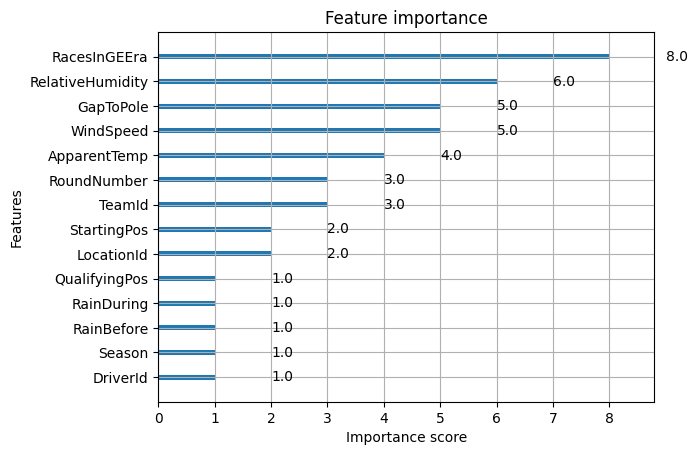

In [35]:
xgb.plot_importance(model.best_estimator_.named_steps["clf"])

In [ ]:
importances = model.best_estimator_.named_steps["clf"].feature_importances_
feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importances_df)

                  Feature  Importance
6              RainBefore    0.371176
1                  TeamId    0.079603
0                DriverId    0.076735
12          QualifyingPos    0.065418
10       RelativeHumidity    0.052224
7              RainDuring    0.047326
4            RacesInGEEra    0.045876
11            StartingPos    0.044370
8               WindSpeed    0.041789
13              GapToPole    0.034200
3             RoundNumber    0.033410
14  TeammateQualifyingPos    0.032994
5              LocationId    0.032780
9            ApparentTemp    0.027645
2                  Season    0.014454


In [41]:
model.best_estimator_.named_steps["clf"].get_booster().get_score()

AttributeError: 'XGBRegressor' object has no attribute 'best_estimator_'

<Axes: >

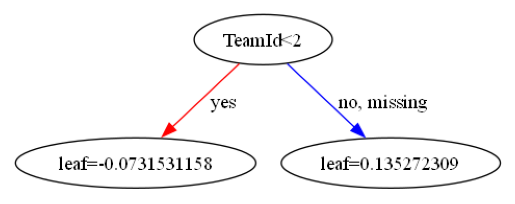

In [62]:
xgb.plot_tree(model.best_estimator_.named_steps["clf"], tree_idx=1)

In [20]:
xgb_model

,objective,'rank:ndcg'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'ndcg'


In [36]:
from xgboost import XGBRegressor

model = XGBRegressor(
    objective="rank:ndcg",
    eval_metric="ndcg",
    tree_method="gpu_hist",  # use your 1650 properly
    device="cuda",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=30
)

model.fit(X_train, y_train)

c:\Users\Admin\Desktop\F1Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:43:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'rank:ndcg'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'ndcg'


In [37]:
get_df_preds(monza_quali, model.predict(monza_quali))

c:\Users\Admin\Desktop\F1Project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [00:43:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


,RaceId,PredictedValue,PredictedRank
0,84,-3.253475,2
1,84,-2.409552,13
2,84,-2.340584,14
3,84,-2.651744,7
4,84,-2.782670,3
5,84,-2.752992,4
6,84,-3.433678,1
7,84,-1.565215,20
8,84,-2.651744,8
9,84,-2.525834,10


In [40]:
model_df_pred = get_df_preds(monza_quali, xgb_predicted_positions)
print("Driver - Quali Pos - XGB1 Model - XGB2 Model - Actual Finishing Pos")
for i, pred in xgb_df_pred.iterrows():
    print(f"{driver_names[monza_quali["DriverId"][i]]} - {monza_quali["StartingPos"][i]} - {xgb_df_pred["PredictedRank"][i]} - {model_df_pred["PredictedRank"][i]} - {monza_results[i]}")

Driver - Quali Pos - XGB1 Model - XGB2 Model - Actual Finishing Pos
Max Verstappen - 1.0 - 1 - 1 - 1.0
Carlos Sainz - 2.0 - 3 - 3 - 3.0
Liam Lawson - 3.0 - 7 - 7 - 5.0
Kimi Antonelli - 4.0 - 4 - 4 - 4.0
George Russell - 5.0 - 5 - 5 - 2.0
Yuki Tsunoda - 6.0 - 2 - 2 - 6.0
Lando Norris - 7.0 - 9 - 9 - 7.0
Isack Hadjar - 8.0 - 10 - 10 - 10.0
Oscar Piastri - 9.0 - 6 - 6 - 20.0
Charles Leclerc - 10.0 - 8 - 8 - 9.0
Fernando Alonso - 11.0 - 11 - 11 - 15.0
Lewis Hamilton - 12.0 - 12 - 12 - 8.0
Gabriel Bortoleto - 13.0 - 13 - 13 - 11.0
Lance Stroll - 14.0 - 14 - 14 - 17.0
Oliver Bearman - 15.0 - 15 - 15 - 12.0
Franco Colapinto - 16.0 - 16 - 16 - 19.0
Nico Hulkenberg - 17.0 - 17 - 17 - 16.0
Pierre Gasly - 18.0 - 18 - 18 - 18.0
Alexander Albon - 19.0 - 19 - 19 - 13.0
Esteban Ocon - 20.0 - 20 - 20 - 14.0
